<a href="https://colab.research.google.com/github/Anatoly-Makarevich/time-series-mentoring/blob/master/4_Classic_Univariate/Topic_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic 4 - Classical Univariate Forecasting

## Overview

This topic finally approaches basic univariate (1-variable) time series forecasting.
We go over several no-learning baseline models, ARIMA, and even the Prophet model.

## Learning Materials

1. Watch the first 3-4 lessons in this [video course](https://classroom.udacity.com/courses/ud980/).

2. Read the following chapters from FPP3:
   - [Chapter 7 - Regression](https://otexts.com/fpp3/regression.html)
   - [Chapter 8 - Smoothing](https://otexts.com/fpp3/expsmooth.html)
   - [Chapter 9 - ARIMA](https://otexts.com/fpp3/arima.html)
   - [Section 13.4 - Combining Forecasts](https://otexts.com/fpp3/combinations.html)

3. Browse the [documentation for the Prophet package](https://facebook.github.io/prophet/docs/quick_start.html)
   and see how previous topics are incorporated into the model.

4. Check out common time series evaluation metrics, their advantages and disadvantages from
   [this table](https://sites.google.com/site/nttrungmtwiki/home/it/data-mining/time-series-analysis/time-series-forecasting-performance-metrics-comparison).

## Tasks

1. Use this [Bike sharing dataset](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset), specifically hour.csv

2. Predict CNT variable using baseline models (Smoothing, Naive model).

3. Predict CNT variable using ARIMA, SARIMA, Prophet and other possible autoregressive models you would like to use.

4. Compare models performance with each other and vs. baseline
   (come up with metrics that include baseline in calculations) on the last 6 months
   (using backtesting) using the evaluation metrics from the learning materials.

5. Test performance for different horizons - 1 day, 1 week, 1 month

6. Perform residual analysis.

You may reference [this notebook from the Statsmodels docs](https://www.statsmodels.org/dev/examples/notebooks/generated/autoregressions.html)


In [46]:
import warnings

# np and pandas
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.api import Holt
from statsmodels.tsa.seasonal import STL

# sktime functionaliy
from sktime.forecasting.compose import make_reduction

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import (mean_absolute_error, mean_squared_error,
                                                    mean_absolute_percentage_error, mean_absolute_scaled_error)

# set style of plots
plt.style.use('Solarize_Light2')

Text(0.5, 1.0, 'Bikes count')

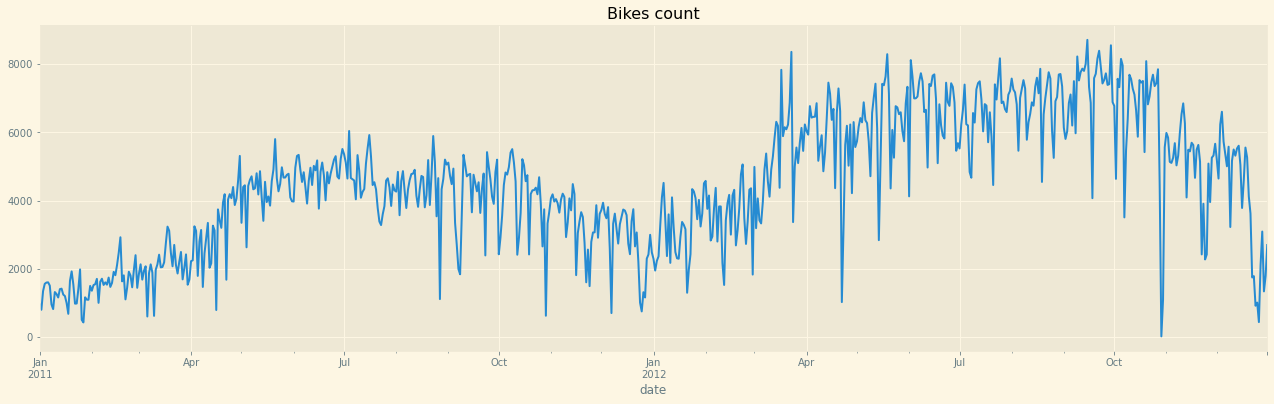

In [100]:
bikes_df = pd.read_csv("../../../data/bikes/hour.csv").assign(
    date=lambda df: pd.to_datetime(df.dteday)
)
bikes_ts = bikes_df.groupby('date').sum()['cnt']


ax = bikes_ts.plot(figsize=(22, 6))
ax.set_title("Bikes count")


There is probably weekly seasonality as well as a monthly one. Also, the variance is not constant, so we'll need to transform the data.

In [16]:
season = 7
bikes_ts = bikes_ts.reindex(
  pd.date_range(min(bikes_ts.index), max(bikes_ts.index), freq='D')
)

y = bikes_ts

start_date = pd.to_datetime('2012-01-01')
end_date = pd.to_datetime('2012-07-01')

y_train = y[(y.index >= start_date) & (y.index < end_date)]

In [47]:
forecasters = {
  'Mean': NaiveForecaster(strategy='mean'),
  'ARIMA': ARIMA(order=(1, 0, 1), seasonal_order=(1, 1, 1, 7), suppress_warnings=True),
  'Linear Regression': make_reduction(estimator=LinearRegression(), strategy='recursive', window_length=10),
  'KNN Regressor': make_reduction(estimator=KNeighborsRegressor(n_neighbors=2), strategy='recursive'),
  'DecisionTreeRegressor': make_reduction(estimator=DecisionTreeRegressor()),
  'Seasonal Naive': NaiveForecaster(strategy='last', sp=season),
  'Auto ETS': AutoETS(trend='add', seasonal='additive', sp=season),
  # 'BATS' : BATS(use_box_cox=False, use_trend=True, sp=[season, 24], use_arma_errors=False, n_jobs=1),
  'TBATS': TBATS(use_box_cox=False, use_trend=True, sp=[season, 7], use_arma_errors=False, n_jobs=1),
  'Prophet': Prophet(yearly_seasonality=False)
}

# Fit the forecasters:
[model.fit(y_train) for _, model in forecasters.items()];

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [48]:
from functools import partial as prtl

# define different metrics to check performances of the models
metrics = {
    'RMSE': prtl(mean_squared_error, square_root=True),
    'MASE': prtl(mean_absolute_scaled_error, y_train=y_train),

    'MAPE': mean_absolute_percentage_error,
    'MAE':  mean_absolute_error
}

In [20]:
def get_forecasts(models, horizon, ensemble=True):
    n = len(models)
    forecasts = {
        name: model.predict(horizon) for name, model in models.items()
    }
    if ensemble:
        # mean of all the models
        forecasts['Ensemble'] = sum(forecasts.values()) / n

    return forecasts

def get_metrics_results(forecasts, actual):
    return pd.DataFrame({
        metric_name: [
            metric(actual, y_pred) for y_pred in forecasts.values()
        ] for metric_name, metric in metrics.items()
    },
    index=forecasts.keys())

### 1 Day Forecast

In [21]:
warnings.filterwarnings('ignore')

# define a 1 day ahead foreast horizon
forecast_date = end_date + pd.DateOffset(days=1)
y_test = y[(y.index >= end_date) & (y.index < forecast_date)]
day_ahead_horizon = ForecastingHorizon(y_test.index, is_relative=False)

# get predictions\forecasts for that specific horizon
forecasts = get_forecasts(forecasters, day_ahead_horizon, ensemble=True);

# show the results for the different forecasters and different required metrics
metrics_results = get_metrics_results(forecasts, y_test)

In [22]:
metrics_results

,RMSE,MASE,MAPE,MAE
Last,156.000000,0.172466,0.027812,156.000000
Mean,378.939560,0.418938,0.070942,378.939560
Drift,174.745856,0.193191,0.031103,174.745856
ARIMA,928.811381,1.026850,0.154921,928.811381
Linear Regression,1014.909805,1.122036,0.168074,1014.909805
KNN Regressor,714.000000,0.789365,0.121264,714.000000
Seasonal Naive,1360.000000,1.503552,0.218966,1360.000000
Auto ETS,952.969325,1.053558,0.158630,952.969325
TBATS,502.552968,0.555599,0.086913,502.552968
Prophet,1353.123108,1.495949,0.217980,1353.123108


### One day forecast metrics results

# 1 Week Forecast

In [23]:
# define a 1 week ahead horizon
forecast_date = end_date + pd.DateOffset(weeks=1)
y_test = y[(y.index >= end_date) & (y.index < forecast_date)]

week_ahead_horizon = ForecastingHorizon(y_test.index, is_relative=False)

In [24]:
warnings.filterwarnings('ignore')
forecasts = get_forecasts(forecasters, week_ahead_horizon)
metrics_results = get_metrics_results(forecasts, y_test);


In [25]:
metrics_results

,RMSE,MASE,MAPE,MAE
Last,886.570116,0.838009,0.125644,758.000000
Mean,1255.602839,1.211164,0.187590,1095.528257
Drift,857.844592,0.802481,0.120048,725.864246
ARIMA,1264.832961,1.100961,0.156017,995.846452
Linear Regression,794.573321,0.673898,0.099602,609.557370
KNN Regressor,969.120478,0.862331,0.125056,780.000000
Seasonal Naive,797.177252,0.788259,0.115667,713.000000
Auto ETS,1033.840806,0.894647,0.129659,809.230129
TBATS,795.329109,0.755691,0.111220,683.540979
Prophet,1413.612413,1.296145,0.179441,1172.395192


Text(0.5, 1.0, 'Observed series and top 4 models predictions')

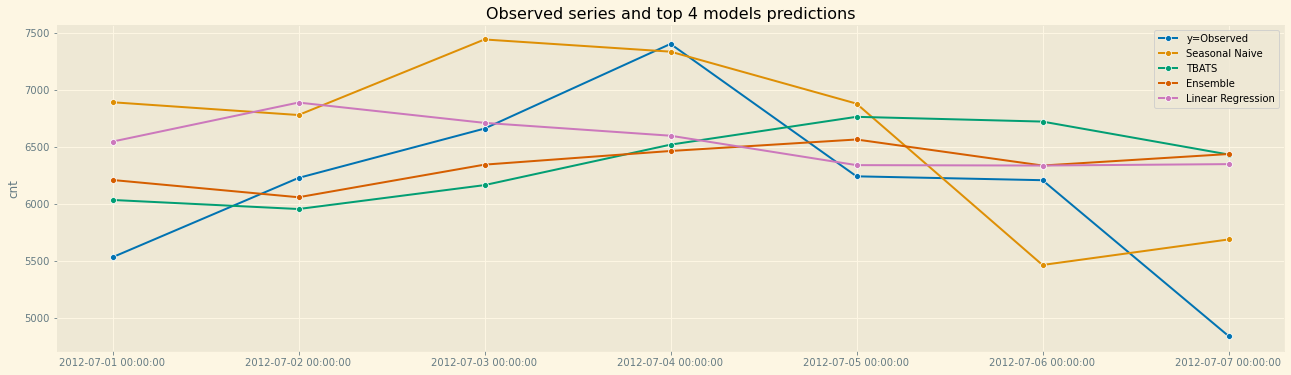

In [26]:
# plot top 4 models by RMSE
top_4_model_names = metrics_results.RMSE.sort_values().index[:4]
top_4_models = {k: forecasts[k] for k in forecasts.keys() & top_4_model_names}

fig, ax = plot_series(
    y_test,
    *tuple(top_4_models.values()),
    labels=['y=Observed'] + list(top_4_models.keys())
)

fig.set_figwidth(22)
fig.set_figheight(6)

ax.set_title("Observed series and top 4 models predictions")

# 1 Month Forecast

In [87]:
forecast_date = end_date + pd.DateOffset(months=1)
y_test = y[(y.index >= end_date) & (y.index < forecast_date)]

month_ahead_horizon = ForecastingHorizon(y_test.index, is_relative=False)
train_horizon = ForecastingHorizon(y_train.index, is_relative=False)

In [75]:
warnings.filterwarnings('ignore')
forecasts = get_forecasts(forecasters, month_ahead_horizon)
metrics_results = get_metrics_results(forecasts, y_test)

In [76]:
metrics_results

,RMSE,MASE,MAPE,MAE
Last,1226.317041,1.205481,0.174568,1090.387097
Mean,1653.040475,1.671292,0.251235,1511.725452
Drift,998.346802,0.959261,0.137054,867.675281
ARIMA,1220.461431,0.974949,0.132656,881.865478
Linear Regression,883.834591,0.801703,0.113644,725.160069
KNN Regressor,1313.363964,1.152022,0.166437,1042.032258
DecisionTreeRegressor,1068.277344,1.014862,0.144468,917.967742
Seasonal Naive,929.179746,0.807303,0.115569,730.225806
Auto ETS,968.750841,0.830920,0.116667,751.587603
TBATS,886.010848,0.818745,0.116456,740.575092


Text(0.5, 1.0, 'Observed series and top 4 models predictions')

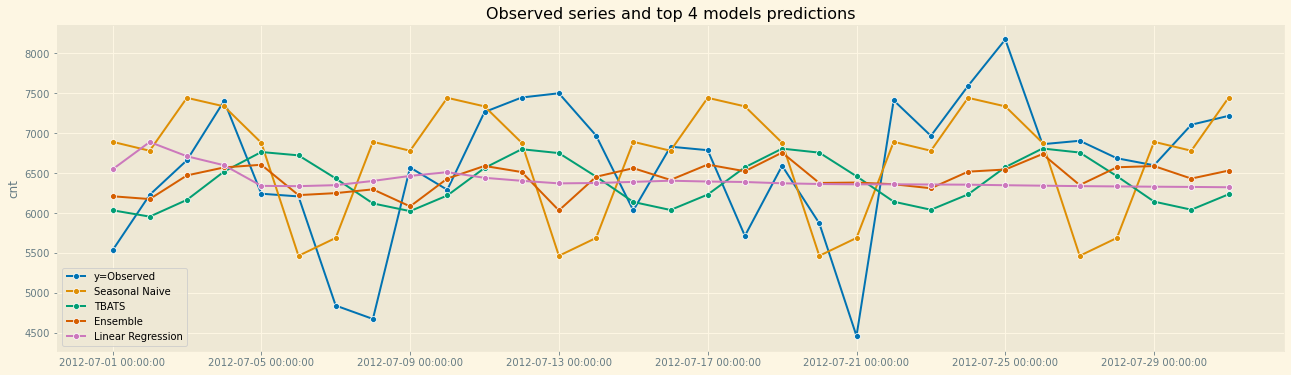

In [99]:
# plot top 4 models by RMSE
top_4_model_names = metrics_results.RMSE.sort_values().index[:4]
top_4_models = {k: forecasts[k] for k in forecasts.keys() & top_4_model_names}

fig, ax = plot_series(
    # y_train,
    y_test,
    *tuple(top_4_models.values()),
    labels=['y=Observed'] + list(top_4_models.keys())
)

fig.set_figwidth(22)
fig.set_figheight(6)

ax.set_title("Observed series and top 4 models predictions")

### Residual Analysis

<AxesSubplot:ylabel='Density'>

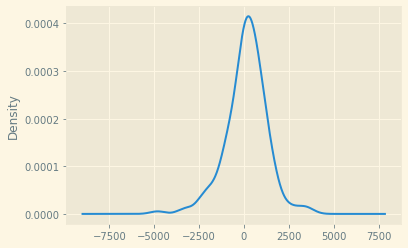

In [98]:
x = forecasters['ARIMA']
x.predict_residuals().plot.density()

In [63]:
residuals.mean()

109.96774193548387